In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import linalg as la
from PIL import Image
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [13]:
raw_data = pd.read_excel('Online Retail.xlsx')
raw_data = raw_data.fillna(0)
raw_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


## Data cleaning

In [15]:
raw_data = raw_data[raw_data['Quantity']>0]
raw_data = raw_data[~raw_data['StockCode'].isnull()]
raw_data['year_week'] = (raw_data['InvoiceDate'].dt.year)*100 + raw_data['InvoiceDate'].dt.week
raw_data = raw_data[~((raw_data['year_week']==201048)|(raw_data['year_week']==201149))]

<ipython-input-15-6a7896235d91>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  raw_data['year_week'] = (raw_data['InvoiceDate'].dt.year)*100 + raw_data['InvoiceDate'].dt.week


In [16]:
raw_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,year_week
10144,537226,22811,SET OF 6 T-LIGHTS CACTI,6,2010-12-06 08:34:00,2.95,15987.0,United Kingdom,201049
10145,537226,21713,CITRONELLA CANDLE FLOWERPOT,8,2010-12-06 08:34:00,2.10,15987.0,United Kingdom,201049
10146,537226,22927,GREEN GIANT GARDEN THERMOMETER,2,2010-12-06 08:34:00,5.95,15987.0,United Kingdom,201049
10147,537226,20802,SMALL GLASS SUNDAE DISH CLEAR,6,2010-12-06 08:34:00,1.65,15987.0,United Kingdom,201049
10148,537226,22052,VINTAGE CARAVAN GIFT WRAP,25,2010-12-06 08:34:00,0.42,15987.0,United Kingdom,201049
...,...,...,...,...,...,...,...,...,...
524198,580537,23266,SET OF 3 WOODEN STOCKING DECORATION,1,2011-12-04 16:08:00,1.25,0.0,United Kingdom,201148
524199,580537,23267,SET OF 4 SANTA PLACE SETTINGS,1,2011-12-04 16:08:00,1.25,0.0,United Kingdom,201148
524200,580537,23312,VINTAGE CHRISTMAS GIFT SACK,2,2011-12-04 16:08:00,4.15,0.0,United Kingdom,201148
524201,580537,23319,BOX OF 6 MINI 50'S CRACKERS,1,2011-12-04 16:08:00,2.49,0.0,United Kingdom,201148


In [17]:
data = raw_data.groupby(['year_week', 'StockCode']).agg({'Quantity': 'sum'}).reset_index()
data = data.pivot_table(index=['StockCode'], columns=['year_week'], values=['Quantity'])
data.columns = data.columns.droplevel(0)

In [21]:
data = data.reset_index().fillna(0)

In [22]:
data

year_week,StockCode,201049,201050,201051,201101,201102,201103,201104,201105,201106,...,201139,201140,201141,201142,201143,201144,201145,201146,201147,201148
0,10002,138.0,41.0,2.0,73.0,42.0,76.0,17.0,133.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,0.0,4.0,0.0,2.0,24.0,46.0,16.0,27.0,0.0
2,10120,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,5.0,0.0,5.0,0.0,38.0,0.0,6.0,1.0,10.0
3,10125,43.0,102.0,7.0,98.0,79.0,36.0,0.0,0.0,0.0,...,197.0,4.0,0.0,20.0,20.0,2.0,0.0,60.0,0.0,6.0
4,10133,14.0,80.0,16.0,11.0,67.0,92.0,10.0,0.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3916,gift_0001_20,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3917,gift_0001_30,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3918,gift_0001_40,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3919,gift_0001_50,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## SVD decomposition

In [23]:
data = data.sample(frac=1)
x = data.iloc[:, 1:].values
u, s, v = la.svd(x, full_matrices=False)

5

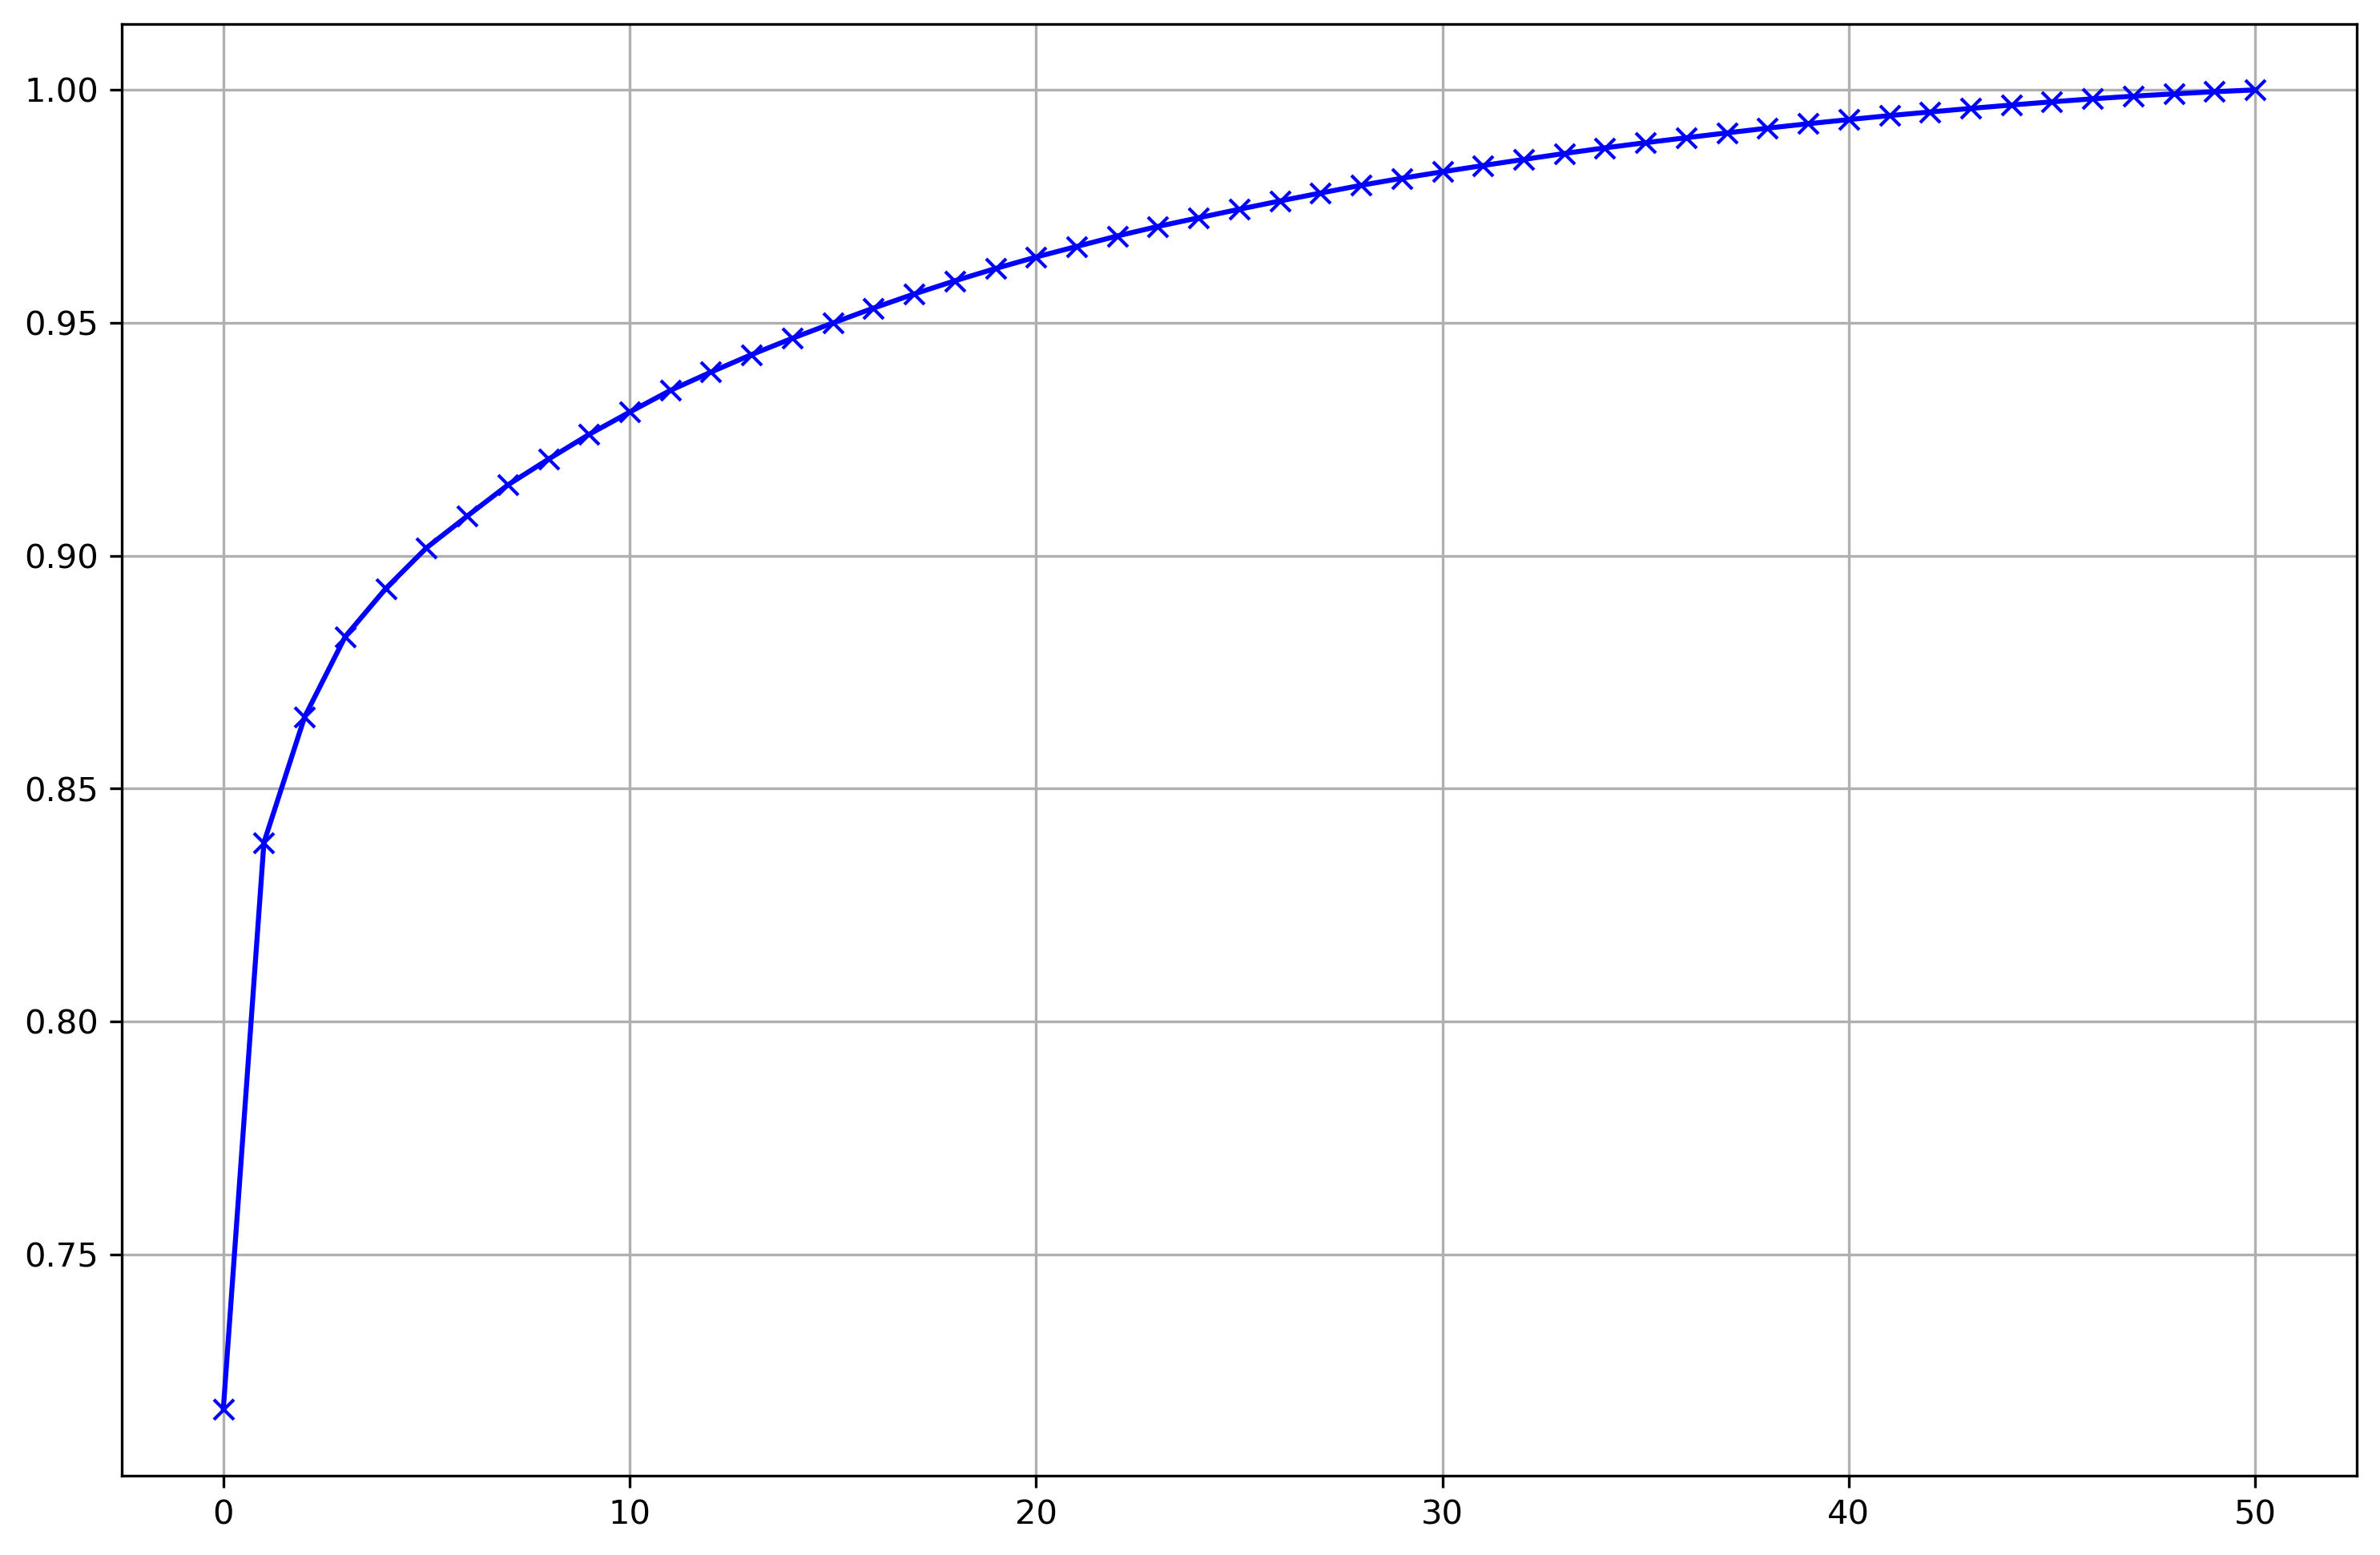

In [31]:
cum_var = []
for i in range(len(s)):
    if i == 0:
        cum_var.append(s[i]**2)
    else:
        cum_var.append(cum_var[-1]+s[i]**2)
cum_var_per = (cum_var / cum_var[-1])
fig = plt.figure(figsize=(12, 8), dpi=300)
plt.plot(range(len(cum_var_per)), cum_var_per, 'bx-')
plt.grid()
min_exp_ratio = .9
feature_nums = 0
for i in cum_var_per:
    if i < min_exp_ratio:
        feature_nums += 1
feature_nums

## coefficient

In [32]:
corr = [[] for i in range(feature_nums)]
t = data['StockCode']
for i in range(len(x)):
    for j in range(feature_nums):
        corr[j].append(np.corrcoef(x[i], v[j, :])[0][1])
for i in range(feature_nums):
    t = pd.concat([t, pd.Series(corr[i], index=data.index)], axis=1)
t.columns = ['StockCode'] + ['v{}'.format(i) for i in range(feature_nums)]

In [33]:
t

,StockCode,v0,v1,v2,v3,v4
488,21400,0.112187,-0.286831,0.172071,-0.122778,-0.207665
2309,23555,0.025043,-0.165734,0.151269,0.178359,-0.087546
3209,84031a,0.019984,-0.192863,0.136589,0.206013,0.021507
3182,81950V,-0.046278,0.095977,-0.094346,-0.053693,-0.024496
3735,90123D,0.044600,-0.017693,0.046151,0.096357,0.107589
...,...,...,...,...,...,...
3273,84536A,0.178071,-0.495881,0.452070,0.200704,-0.029756
375,21224,0.052143,-0.110101,0.044924,0.277251,-0.067487
3190,82011B,0.055119,-0.254605,0.541888,-0.365357,-0.158544
2719,85089,0.045102,-0.260082,0.212045,0.305577,-0.088498
